<a href="https://colab.research.google.com/github/vnvz/Boston-house-prices-analysis/blob/main/boston_housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Organização das colunas e dados

Como os dados estão desorganizados em uma coluna com varios valores separados por um espaço, iremos importar os dados e organizá-los em colunas.

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Dados/housing.csv', header=None, sep='\s+')

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.columns = column_names

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Dicionário de dados
| Nome     | Tipo de Dado | Descrição                                                  |
|----------|--------------|------------------------------------------------------------|
| ZN       | Numérico     | Proporção de terrenos residenciais zonados para lotes com mais de 25.000 pés quadrados.                        |
| INDUS    | Numérico     | Proporção de acres de negócios não varejistas por cidade.   |
| CHAS     | Categórico   | Variável dummy do rio Charles (1 se o lote limita o rio, 0 caso contrário). |
| NOX      | Numérico     | Concentração de óxidos nítricos (partes por 10 milhões).   |
| RM       | Numérico     | Número médio de cômodos por habitação.                    |
| AGE      | Numérico     | Proporção de unidades ocupadas por seus proprietários construídas antes de 1940. |
| DIS      | Numérico     | Distâncias ponderadas para cinco centros de emprego em Boston. |
| RAD      | Numérico     | Índice de acessibilidade a rodovias radiais.              |
| TAX      | Numérico     | Taxa de imposto sobre a propriedade de valor total por $10.000. |
| PTRATIO  | Numérico     | Proporção de alunos por professor na cidade.             |
| LSTAT    | Numérico     | Percentual de status inferior da população.              |
| MEDV     | Numérico     | Valor médio das casas ocupadas por seus proprietários em milhares de dólares. |


# Tratamento, exploração e análise

## Tratamento de dados
Estaremos removendo a coluna `b`, já que ela possui implicações de caratér ético e ela é fora do escopo da análise.

In [6]:
df.drop('B', axis=1, inplace=True)

## Correlação dos dados
Inicialmente, faremos uma matriz de correlação para encontrar as variáveis mais relacionadas a nossa variável-alvo (`MEDV`).

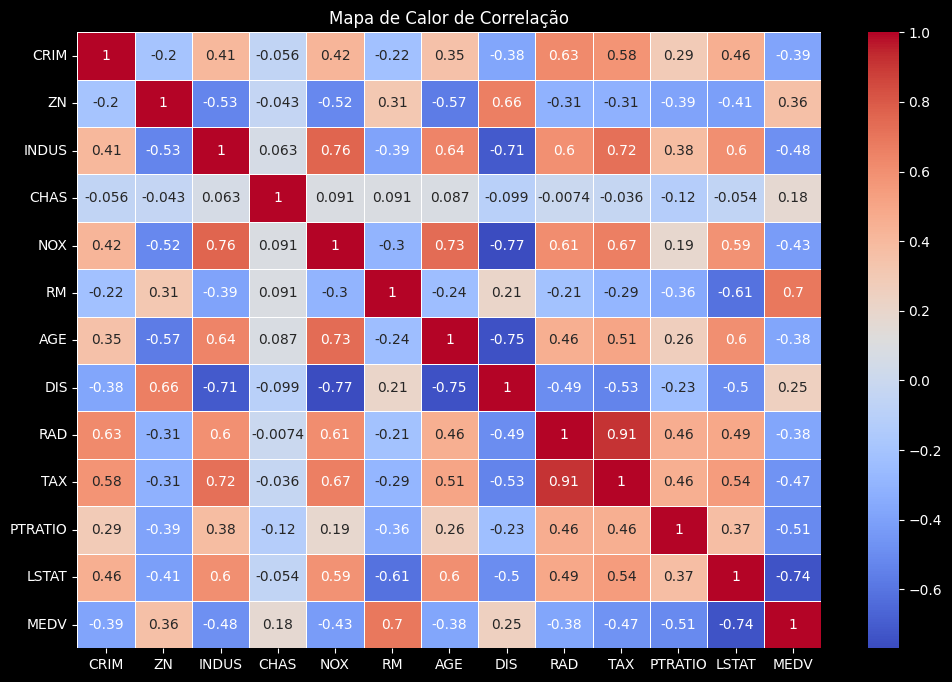

In [7]:
corr_matrix = df.corr()

plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Mapa de Calor de Correlação")
plt.show()

A partir de uma análise simples, temos duas variáveis que possuem uma correlação altíssima, tanto positiva quanto negativa. Essas variáveis sendo `RM` e `LSTAT`.

Para confirmar a sua relação com `MEDV`, iremos realizar o teste de correlação de pearson e plotar a dispersão das duas colunas.

### Teste de correlação de Pearson

In [8]:
# Calculando o coeficiente de correlação de Pearson e o p-valor para a variável "RM"
corr_RM, p_value_RM = stats.pearsonr(df['RM'], df['MEDV'])

# Calculando o coeficiente de correlação de Pearson e o p-valor para a variável "LSTAT"
corr_LSTAT, p_value_LSTAT = stats.pearsonr(df['LSTAT'], df['MEDV'])

print(f"Correlação entre RM e MEDV: {corr_RM}")
print(f"P-valor para RM: {p_value_RM}")

print(f"Correlação entre LSTAT e MEDV: {corr_LSTAT}")
print(f"P-valor para LSTAT: {p_value_LSTAT}")

Correlação entre RM e MEDV: 0.6953599470715394
P-valor para RM: 2.4872288710080976e-74
Correlação entre LSTAT e MEDV: -0.737662726174015
P-valor para LSTAT: 5.081103394387554e-88


### Gráfico de dispersão

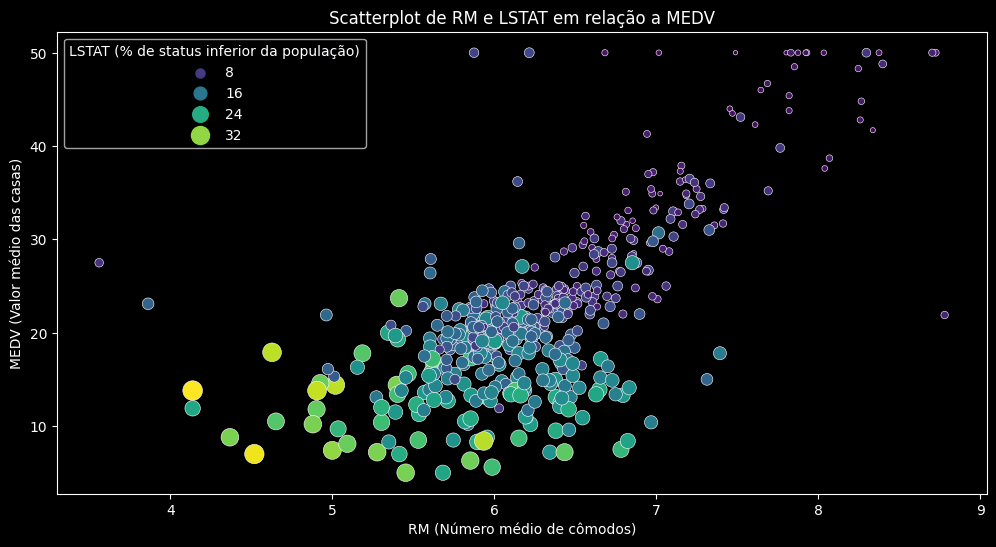

In [9]:
# Crie um scatterplot combinando 'RM' e 'LSTAT' em relação a 'MEDV' com paleta de cores amigável para daltônicos
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='RM', y='MEDV', hue='LSTAT', palette='viridis', size='LSTAT', sizes=(10, 200))
plt.title('Scatterplot de RM e LSTAT em relação a MEDV')
plt.xlabel('RM (Número médio de cômodos)')
plt.ylabel('MEDV (Valor médio das casas)')
plt.legend(title='LSTAT (% de status inferior da população)')
plt.show()

## Escolha da melhor variável de entrada para o modelo
Para seguir com o treinamento, escolhemos a variável `RM` devido ao nosso entendimento que essa variável é bastante significativa para definir o valor das casas, já que quanto mais quartos presentes em cada casa, maior será o valor dela.

# Divisão da base
Aqui, realizamos a divisão da base em treinamento e teste utilizando o método holdout.

Inicialmente utilizaremos apenas a variável RM, porém retornaremos posteriormente para utilizar mais valores.

In [10]:
X = df['RM']
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Regressão linear

## Treinamento do modelo
Abaixo, realizamos o treinamento do modelo com as bases de treinamento.

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Visualização do modelo

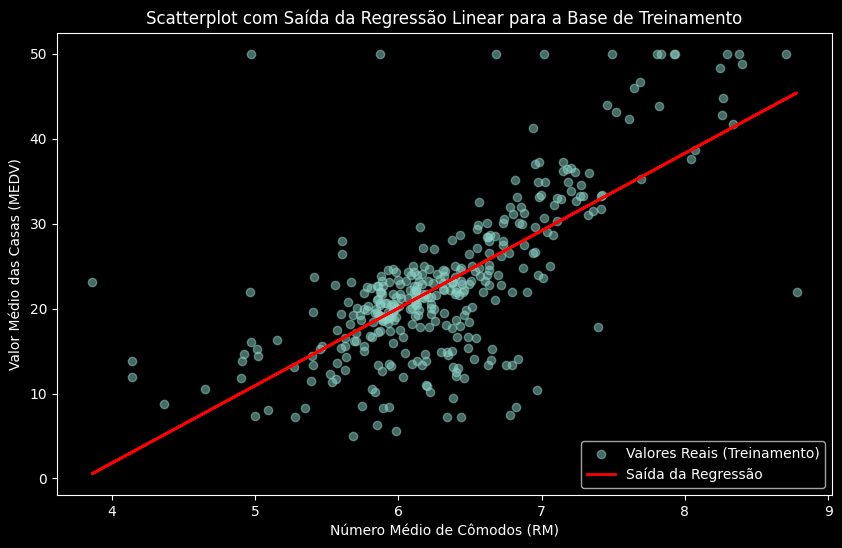

In [12]:
y_pred_train = model.predict(X_train)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.5, label='Valores Reais (Treinamento)')
plt.plot(X_train, y_pred_train, color='red', linewidth=2, label='Saída da Regressão')
plt.title('Scatterplot com Saída da Regressão Linear para a Base de Treinamento')
plt.xlabel('Número Médio de Cômodos (RM)')
plt.ylabel('Valor Médio das Casas (MEDV)')
plt.legend()
plt.show()

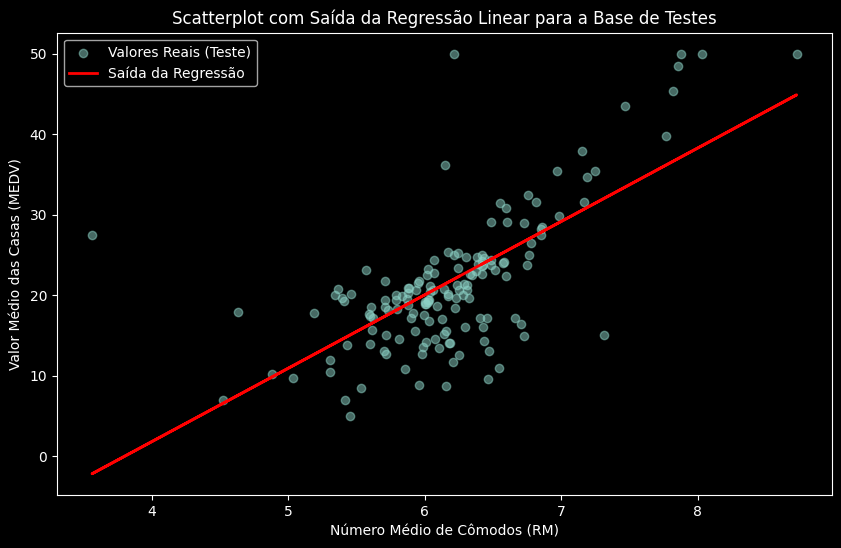

In [13]:
y_pred_test = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.5, label='Valores Reais (Teste)')
plt.plot(X_test, y_pred_test, color='red', linewidth=2, label='Saída da Regressão')
plt.title('Scatterplot com Saída da Regressão Linear para a Base de Testes')
plt.xlabel('Número Médio de Cômodos (RM)')
plt.ylabel('Valor Médio das Casas (MEDV)')
plt.legend()
plt.show()

## R² Score

In [14]:
r2_train = r2_score(y_train, model.predict(X_train))
r2_train = round(r2_train, 2)
print(f"R² no Conjunto de Treinamento: {r2_train}")

r2_test = r2_score(y_test, model.predict(X_test))
r2_test = round(r2_test, 2)
print(f"R² no Conjunto de Teste: {r2_test}")

R² no Conjunto de Treinamento: 0.49
R² no Conjunto de Teste: 0.46


Com os valores do R² encontrados, podemos inferir dois pontos:
- O score no conjunto de treinamento indica que ele possui um juste ok do modelo, mas ainda há o que melhorar.
- O score no conjunto de testes indica que ele está próximo dos treinos, porém ainda há o que melhorar.

## Treinamento com mais variáveis
Agora, vamos voltar um pouco atrás e encontrar as outras variáveis com alta correlação (negativa ou positiva) com a variável alvo, `MEDV`.

In [15]:
positive_correlations = corr_matrix['MEDV'].sort_values(ascending=False)
positive_correlations = positive_correlations[positive_correlations > 0]

negative_correlations = corr_matrix['MEDV'].sort_values(ascending=True)
negative_correlations = negative_correlations[negative_correlations < 0]

print("Variáveis com as maiores correlações positivas:")
print(positive_correlations)
print("\nVariáveis com as maiores correlações negativas:")
print(negative_correlations)

Variáveis com as maiores correlações positivas:
MEDV    1.000000
RM      0.695360
ZN      0.360445
DIS     0.249929
CHAS    0.175260
Name: MEDV, dtype: float64

Variáveis com as maiores correlações negativas:
LSTAT     -0.737663
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
RAD       -0.381626
AGE       -0.376955
Name: MEDV, dtype: float64


Essas variáveis são, excluindo a já utilizada `RM`:
- `LSTAT`
- `PTRATIO`
- `INDUS`
- `TAX`

Utilizaremos essas 5 colunas para os próximos treinamentos

### Divisão da base

In [16]:
X1 = df[['RM', 'LSTAT', 'PTRATIO', 'INDUS', 'TAX']]
y1 = df['MEDV']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

### Treinamento do novo modelo

In [17]:
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

LinearRegression()

### Visualizações do novo modelo

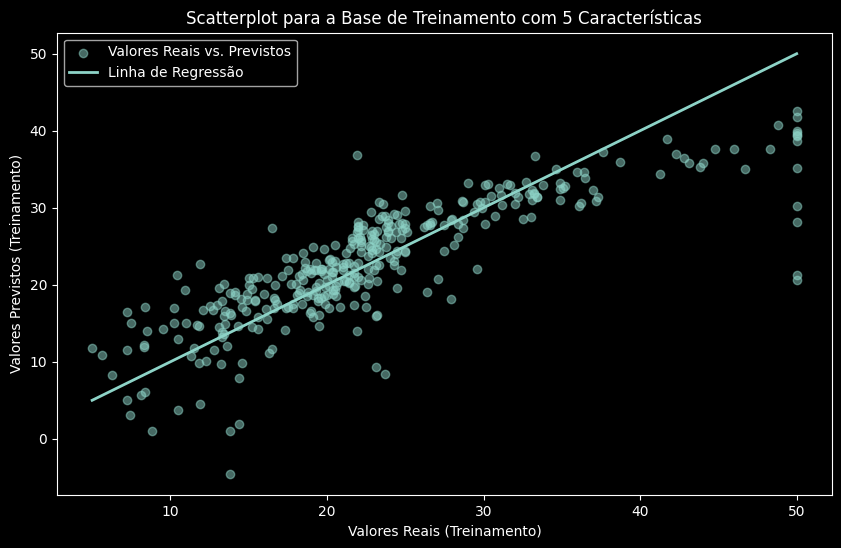

In [18]:
y1_pred_train = model1.predict(X1_train)

plt.figure(figsize=(10, 6))
plt.scatter(y1_train, y1_pred_train, alpha=0.5, label='Valores Reais vs. Previstos')
plt.plot([y1_train.min(), y1_train.max()], [y1_train.min(), y1_train.max()], '-', lw=2, label='Linha de Regressão')
plt.title('Scatterplot para a Base de Treinamento com 5 Características')
plt.xlabel('Valores Reais (Treinamento)')
plt.ylabel('Valores Previstos (Treinamento)')
plt.legend()
plt.show()

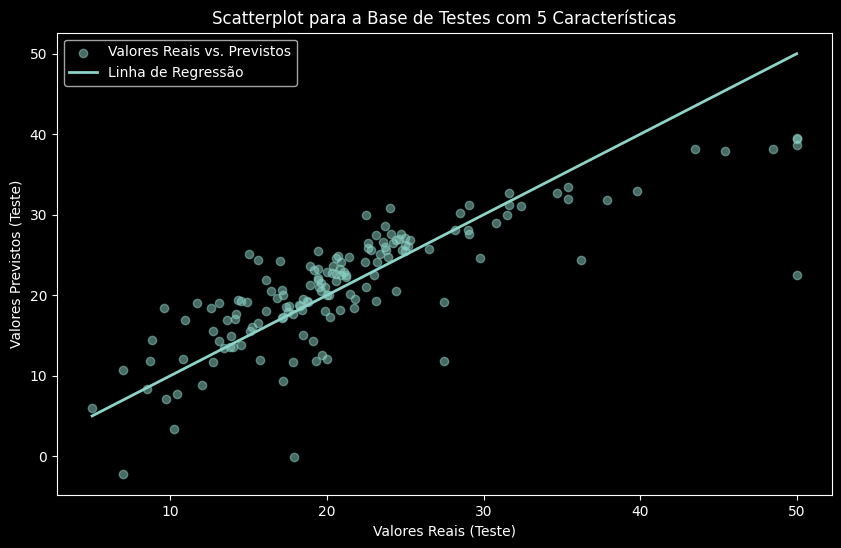

In [19]:
y1_pred_test = model1.predict(X1_test)

plt.figure(figsize=(10, 6))
plt.scatter(y1_test, y1_pred_test, alpha=0.5, label='Valores Reais vs. Previstos')
plt.plot([y1_test.min(), y1_test.max()], [y1_test.min(), y1_test.max()], '-', lw=2, label='Linha de Regressão')
plt.title('Scatterplot para a Base de Testes com 5 Características')
plt.xlabel('Valores Reais (Teste)')
plt.ylabel('Valores Previstos (Teste)')
plt.legend()
plt.show()

### R² Score do novo modelo


In [20]:
r2_train = r2_score(y1_train, y1_pred_train)
r2_train = round(r2_train, 2)
print(f"R² no Conjunto de Treinamento: {r2_train}")

r2_test = r2_score(y1_test, y1_pred_test)
r2_test = round(r2_test, 2)
print(f"R² no Conjunto de Teste: {r2_test}")

R² no Conjunto de Treinamento: 0.69
R² no Conjunto de Teste: 0.65


## Avaliação do novo modelo e comparação com o anterior.
Podemos observar através do R² score que com mais features disponíves para o treinamento do regressor, melhor foi seu desempenho em comparação com apenas um deles.

# Regressão polinomial

## Divisão nova da base

In [21]:
X_pol = df[['RM']]
y_pol = df['MEDV']

X_pol_train, X_pol_test, y_pol_train, y_pol_test = train_test_split(X_pol, y_pol, test_size=0.3, random_state=42)

## Treinamento do modelo
Abaixo, utilizando a divisão anterior da base, realizaremos o treinamento com graus de polinômios diferentes (`2`, `3` e `5`)

In [22]:
# Modelo de Regressão Polinomial de Grau 2
poly2_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly2_model.fit(X_pol_train, y_pol_train)

# Modelo de Regressão Polinomial de Grau 3
poly3_model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
poly3_model.fit(X_pol_train, y_pol_train)

# Modelo de Regressão Polinomial de Grau 5
poly5_model = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
poly5_model.fit(X_pol_train, y_pol_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

## Visalização dos modelos polinomiais

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


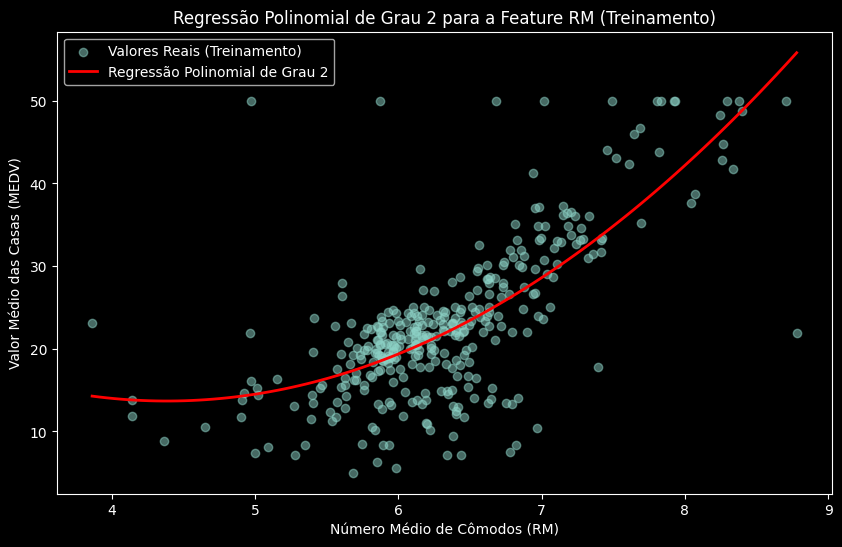

In [23]:
X_range = np.linspace(X_pol_train.min(), X_pol_train.max(), 100).reshape(-1, 1)

y_poly2_range = poly2_model.predict(X_range)

plt.figure(figsize=(10, 6))
plt.scatter(X_pol_train, y_pol_train, label='Valores Reais (Treinamento)', alpha=0.5)
plt.plot(X_range, y_poly2_range, color='red', label='Regressão Polinomial de Grau 2', lw=2)
plt.title('Regressão Polinomial de Grau 2 para a Feature RM (Treinamento)')
plt.xlabel('Número Médio de Cômodos (RM)')
plt.ylabel('Valor Médio das Casas (MEDV)')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


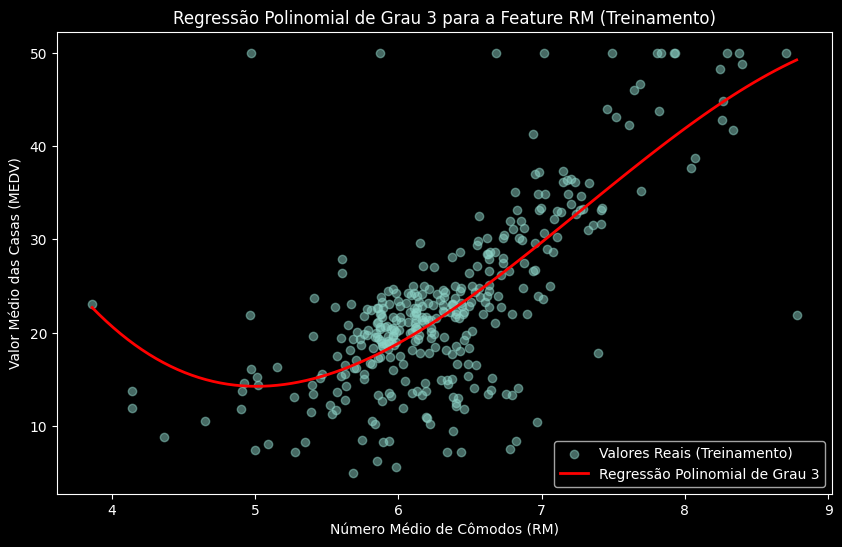

In [24]:
# Crie um modelo de regressão polinomial de grau 3
X_range = np.linspace(X_pol_train.min(), X_pol_train.max(), 100).reshape(-1, 1)

# Preveja os valores com o modelo polinomial de grau 3
y_poly3_range = poly3_model.predict(X_range)

# Crie o gráfico de dispersão com a regressão polinomial de grau 3
plt.figure(figsize=(10, 6))
plt.scatter(X_pol_train, y_pol_train, label='Valores Reais (Treinamento)', alpha=0.5)
plt.plot(X_range, y_poly3_range, color='red', label='Regressão Polinomial de Grau 3', lw=2)
plt.title('Regressão Polinomial de Grau 3 para a Feature RM (Treinamento)')
plt.xlabel('Número Médio de Cômodos (RM)')
plt.ylabel('Valor Médio das Casas (MEDV)')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


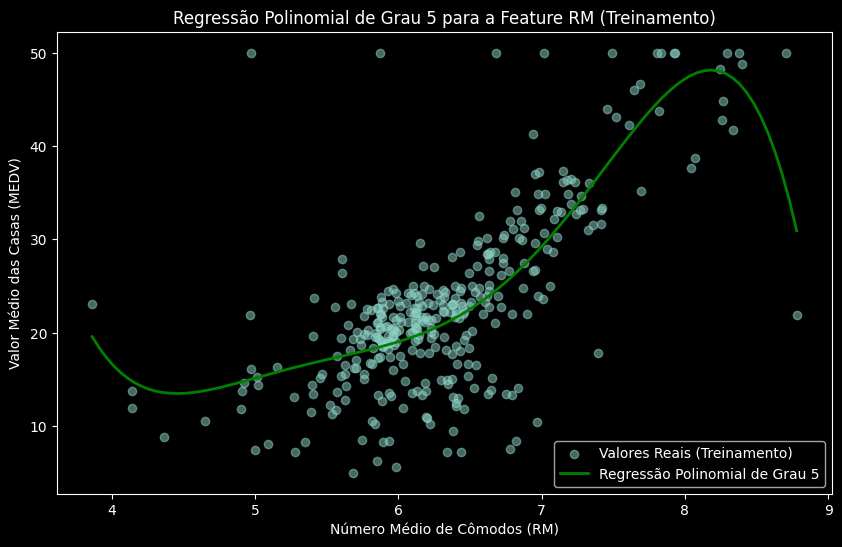

In [25]:
# Crie um modelo de regressão polinomial de grau 5
X_range = np.linspace(X_pol_train.min(), X_pol_train.max(), 100).reshape(-1, 1)

# Preveja os valores com o modelo polinomial de grau 5
y_poly5_range = poly5_model.predict(X_range)

# Crie o gráfico de dispersão com a regressão polinomial de grau 5
plt.figure(figsize=(10, 6))
plt.scatter(X_pol_train, y_pol_train, label='Valores Reais (Treinamento)', alpha=0.5)
plt.plot(X_range, y_poly5_range, color='green', label='Regressão Polinomial de Grau 5', lw=2)
plt.title('Regressão Polinomial de Grau 5 para a Feature RM (Treinamento)')
plt.xlabel('Número Médio de Cômodos (RM)')
plt.ylabel('Valor Médio das Casas (MEDV)')
plt.legend()
plt.show()

## R² Score dos modelos polinomiais

In [26]:
# Modelo de Regressão Polinomial de Grau 2
y_poly2_pred = poly2_model.predict(X_pol_test)
r2_score_poly2 = r2_score(y_pol_test, y_poly2_pred)

# Modelo de Regressão Polinomial de Grau 3
y_poly3_pred = poly3_model.predict(X_pol_test)
r2_score_poly3 = r2_score(y_pol_test, y_poly3_pred)

# Modelo de Regressão Polinomial de Grau 5
y_poly5_pred = poly5_model.predict(X_pol_test)
r2_score_poly5 = r2_score(y_pol_test, y_poly5_pred)

# Imprima os valores de R² score para cada modelo
print(f"R² Score para Regressão Polinomial de Grau 2: {r2_score_poly2:.2f}")
print(f"R² Score para Regressão Polinomial de Grau 3: {r2_score_poly3:.2f}")
print(f"R² Score para Regressão Polinomial de Grau 5: {r2_score_poly5:.2f}")

R² Score para Regressão Polinomial de Grau 2: 0.57
R² Score para Regressão Polinomial de Grau 3: 0.58
R² Score para Regressão Polinomial de Grau 5: 0.58


contextualização

# [EXTRA] Comparação com outros modelos com regularizações Ridge e Lasso
Aqui, vamos selecionar o modelo de Regressão Linear com 5 features e compará-lo ao mesmo modelo utilizando as regularizações.

Inicialmente, utilizaremos o valor de alpha igual a `1`, porém depois testaremos outros utilizando a validação K-Fold

In [27]:
# Modelo Ridge
alpha_ridge = 1.0

model_ridge = Ridge(alpha=alpha_ridge)
model_ridge.fit(X1_train, y1_train)


# Modelo Lasso
alpha_lasso = 1.0

model_lasso = Lasso(alpha=alpha_lasso)
model_lasso.fit(X1_train, y1_train)

Lasso()

## Visualização dos modelos - Linear x Ridge x Lasso

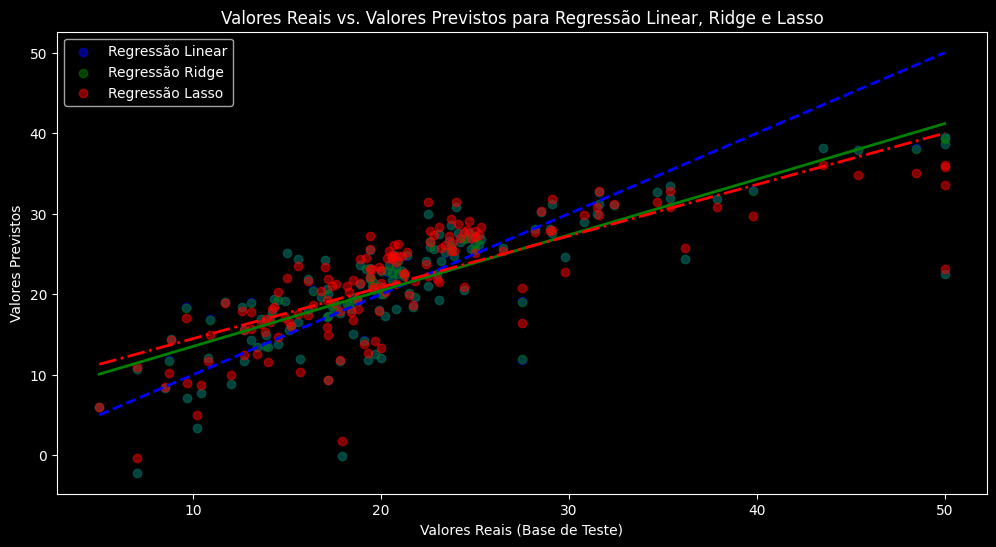

In [28]:
# Valores Reais
y_real = y1_test

# Valores Previstos pelos Modelos
y_pred_linear = model1.predict(X1_test)
y_pred_ridge = model_ridge.predict(X1_test)
y_pred_lasso = model_lasso.predict(X1_test)

# Crie um array de valores de x para as linhas de regressão
x_range = np.linspace(min(y_real), max(y_real), len(y_real))

plt.figure(figsize=(12, 6))

# Gráfico de Valores Reais vs. Valores Previstos (Regressão Linear)
plt.scatter(y_real, y_pred_linear, alpha=0.5, label='Regressão Linear', color='blue')
plt.plot(x_range, x_range, color='blue', linestyle='--', lw=2)

# Gráfico de Valores Reais vs. Valores Previstos (Regressão Ridge)
plt.scatter(y_real, y_pred_ridge, alpha=0.5, label='Regressão Ridge', color='green')
plt.plot(np.unique(y_real), np.poly1d(np.polyfit(y_real, y_pred_ridge, 1))(np.unique(y_real)), color='green', linestyle='-', lw=2)

# Gráfico de Valores Reais vs. Valores Previstos (Regressão Lasso)
plt.scatter(y_real, y_pred_lasso, alpha=0.5, label='Regressão Lasso', color='red')
plt.plot(np.unique(y_real), np.poly1d(np.polyfit(y_real, y_pred_lasso, 1))(np.unique(y_real)), color='red', linestyle='-.', lw=2)
plt.xlabel('Valores Reais (Base de Teste)')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Valores Previstos para Regressão Linear, Ridge e Lasso')
plt.legend()
plt.show()

## R² Score - Linear x Ridge x Lasso

In [29]:
# Calcule o R² score para o modelo de Regressão Linear
r2_score_linear = r2_score(y1_test, y_pred_linear)

# Calcule o R² score para o modelo de Regressão Ridge
r2_score_ridge = r2_score(y1_test, y_pred_ridge)

# Calcule o R² score para o modelo de Regressão Lasso
r2_score_lasso = r2_score(y1_test, y_pred_lasso)

# Imprima os valores de R² score para cada modelo
print(f"R² Score para Regressão Linear: {r2_score_linear:.2f}")
print(f"R² Score para Regressão Ridge: {r2_score_ridge:.2f}")
print(f"R² Score para Regressão Lasso: {r2_score_lasso:.2f}")

R² Score para Regressão Linear: 0.65
R² Score para Regressão Ridge: 0.65
R² Score para Regressão Lasso: 0.61


Baseado no R² score, o modelo Ridge se igualou ao modelo original. Agora, vamos realizar validações cruzadas k-fold para definir qual o melhor valor de alpha.

## Validação cruzada K-Fold

In [30]:
# Valores de alpha que deseja testar
alphas = [0.1, 1.0, 10.0, 100.0]

# Lista para armazenar os R² scores para Ridge
r2_scores_ridge = []

# Lista para armazenar os R² scores para Lasso
r2_scores_lasso = []

# Realize a validação cruzada k-fold para Ridge e Lasso
for alpha in alphas:
    # Modelo de Ridge com o valor de alpha atual
    model_ridge = Ridge(alpha=alpha)

    # Calcule os R² scores para Ridge usando validação cruzada
    r2_scores_ridge.append(cross_val_score(model_ridge, X1, y1, cv=5, scoring='r2').mean())

    # Modelo de Lasso com o valor de alpha atual
    model_lasso = Lasso(alpha=alpha)

    # Calcule os R² scores para Lasso usando validação cruzada
    r2_scores_lasso.append(cross_val_score(model_lasso, X1, y1, cv=5, scoring='r2').mean())

# Imprima os R² scores para Ridge e Lasso
print("R² Scores para Ridge com diferentes valores de alpha:")
for alpha, r2 in zip(alphas, r2_scores_ridge):
    print(f"Alpha = {alpha}: R² Score = {r2:.2f}")

print("\nR² Scores para Lasso com diferentes valores de alpha:")
for alpha, r2 in zip(alphas, r2_scores_lasso):
    print(f"Alpha = {alpha}: R² Score = {r2:.2f}")

R² Scores para Ridge com diferentes valores de alpha:
Alpha = 0.1: R² Score = 0.38
Alpha = 1.0: R² Score = 0.39
Alpha = 10.0: R² Score = 0.40
Alpha = 100.0: R² Score = 0.44

R² Scores para Lasso com diferentes valores de alpha:
Alpha = 0.1: R² Score = 0.39
Alpha = 1.0: R² Score = 0.38
Alpha = 10.0: R² Score = 0.25
Alpha = 100.0: R² Score = -0.20


Baseando-se nos R² scores, vamos treinar novamente os modelos utilizando os valores de alpha correspondentes.

### Treinamento dos modelos pós k-fold

In [31]:
# Modelo Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X1_train, y1_train)

# Modelo Lasso
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X1_train, y1_train)

Lasso(alpha=0.1)